In [1]:
from tifffile import imread, imwrite
import os


seg_dir = 'D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/timelapse_third_dataset.tif'

data_prefix = 'timelapse_third_dataset_'
seg_img = imread(seg_dir)



In [2]:
import torch
cuda_available = torch.cuda.is_available()

# Get the name of the GPU
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No GPU available"

print("CUDA available:", cuda_available)
print("GPU Name:", gpu_name)

CUDA available: True
GPU Name: NVIDIA GeForce RTX 3090


In [4]:
import pandas as pd
import numpy as np 
from torch.utils.data import DataLoader
import torch
from cellshape_cloud import CloudAutoEncoder
from kapoorlabs_lightning.pytorch_losses import ChamferLoss
from kapoorlabs_lightning.optimizers import Adam
from napatrackmater import load_json
from kapoorlabs_lightning.lightning_trainer import AutoLightningModel
from torch.utils.data import Dataset
from pyntcloud import PyntCloud
from pathlib import Path
import cellshape_helper as helper
import umap
import matplotlib.pyplot as plt

In [18]:
from tqdm import tqdm
# Create 3D Images from Frames

save_dir = 'D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/Crop_Frame258_to_369/'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)
Frame_start = 257 # set 257 for 258
Frame_end = 369 
for frame in tqdm(range(Frame_start, Frame_end), desc="Processing Frames"): #(257 to 368)
    # Extract the 3D image for the current frame
    img_3d = seg_img[frame]
    # Construct the file name
    file_name = os.path.join(save_dir, f"{data_prefix}{frame+1}.tif")

    # Save the 3D image
    imwrite(file_name, img_3d)

Processing Frames: 100%|██████████| 112/112 [01:07<00:00,  1.65it/s]


In [42]:
# 3D Image to pointcloud
cloud_dataset_dir = 'D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/Crop/cloudpoint_Frame_258_to_369'
real_mask_dir = 'D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/Crop_Frame258_to_369/'
num_points = 2048
min_size = (5,16,16)
helper.label_tif_to_pc_directory(real_mask_dir, cloud_dataset_dir,num_points, min_size = min_size)

  0%|          | 0/112 [00:00<?, ?it/s]c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\cellshape_helper\vendor\pytorch_geometric_files.py:65: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Cross.cpp:67.)
  area = (pos[face[1]] - pos[face[0]]).cross(pos[face[2]] - pos[face[0]])
100%|██████████| 112/112 [3:53:55<00:00, 125.31s/it] 


In [43]:
model_path = 'MembraneCloud/xenopus_membrane_autoencoder.ckpt'
model_path_json = 'MembraneCloud/xenopus_membrane_autoencoder.json'

loss = ChamferLoss()
optimizer = Adam(lr=0.004)
modelconfig = load_json(model_path_json)
cloud_autoencoder = CloudAutoEncoder(
                                    num_features=modelconfig["num_features"],
                                    k=modelconfig["k_nearest_neighbours"],
                                    encoder_type=modelconfig["encoder_type"],
                                    decoder_type=modelconfig["decoder_type"],
                                    )
autoencoder = AutoLightningModel.load_from_checkpoint(model_path, network = cloud_autoencoder, 
                                                      loss_func = loss, optim_func = optimizer)

In [44]:
class PointCloudDataset(Dataset):
    # usding kapoorlabs_lightning PointCloudDataset class scale parameters and add filename
    def __init__(self, points_dir, centre=True, scale_z=1.0, scale_xy=1.0):
        self.points_dir = points_dir
        self.centre = centre
        self.scale_z = scale_z
        self.scale_xy = scale_xy
        self.p = Path(self.points_dir)
        self.files = list(self.p.glob("**/*.ply"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # read the image
        file = self.files[idx]
        point_cloud = PyntCloud.from_file(str(file))
        mean = 0
        point_cloud = torch.tensor(point_cloud.points.values)
        if self.centre:
            mean = torch.mean(point_cloud, 0)

        scale = torch.tensor([[self.scale_z, self.scale_xy, self.scale_xy]])
        point_cloud = (point_cloud - mean) / scale

        return point_cloud, str(file)

In [45]:
features = []
filenames = []

# load parameter from json file
scale_z = modelconfig['scale_z'] 
scale_xy= modelconfig['scale_xy']

input_dir = 'D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/cloudpoint_Frame_258_to_369/point_cloud/'
dataset = PointCloudDataset(input_dir, scale_z=scale_z, scale_xy=scale_xy)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for data, file in tqdm(dataloader, desc="Processing"):
        point_cloud = data.to('cuda')
        encoded_features = autoencoder.network.encoder(point_cloud)
        # NumPy is designed to operate on the CPU
        features.append(encoded_features.cpu().numpy())
        filenames.append(file)
features = np.concatenate(features, axis=0)
filenames = np.concatenate(filenames, axis=0)

Processing: 100%|██████████| 1632/1632 [1:13:46<00:00,  2.71s/it]


In [46]:

assert len(features) == len(filenames), "Features and filenames lengths do not match."

df = pd.DataFrame(features)
df['filename'] = filenames 
df.to_csv('D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/encoder_features_258_369.csv', index=False)

In [50]:
data = pd.read_csv('D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/encoder_features_258_369.csv')
df_features = data.drop(columns='filename')

In [48]:
# create time and label columns
import re

def extract_timeframe_label_from_dataframe(df, filename_column):
    """
    Extracts timeframe and label from the filename column of a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing the filename column.
    filename_column (str): Name of the column containing the filenames.

    Returns:
    pd.DataFrame: DataFrame with two new columns 'timeframe' and 'label' added.
    """
    def extract_timeframe_label(filename):
        matches = re.search(r'_(\d+)_(\d+).ply', filename)
        if matches:
            return int(matches.group(1)), int(matches.group(2))
        else:
            return None, None

    df['timeframe'], df['membrane_label'] = zip(*df[filename_column].apply(extract_timeframe_label))
    return df

df = extract_timeframe_label_from_dataframe(data, 'filename')
df.to_csv('D:/Ziwei/Mari_Third_Dataset_Analysis/seg_membrane_timelapses2/encoder_features_with_label_258_369.csv', index=False)

In [51]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
scaled_features = scalar.fit_transform(np.asarray(df_features.iloc[:, 0:64]))
reducer = umap.UMAP(random_state=42)  
embedding = reducer.fit_transform(scaled_features)

c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


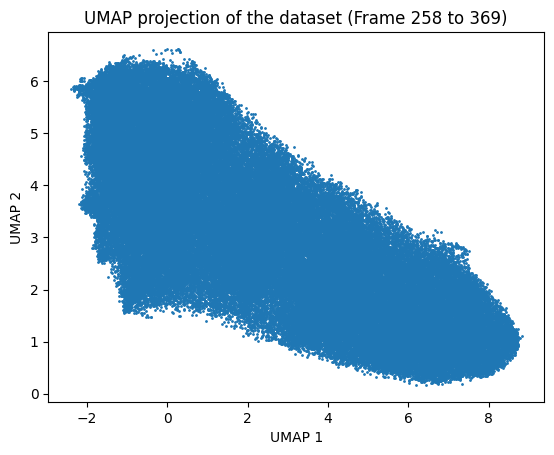

In [59]:
plt.scatter(embedding[:, 0], embedding[:, 1],s=1)
plt.title("UMAP projection of the dataset (Frame 258 to 369)")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [53]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(embedding)

# Evaluate the densities on the embedding itself
log_density = kde.score_samples(embedding)
density = np.exp(log_density)

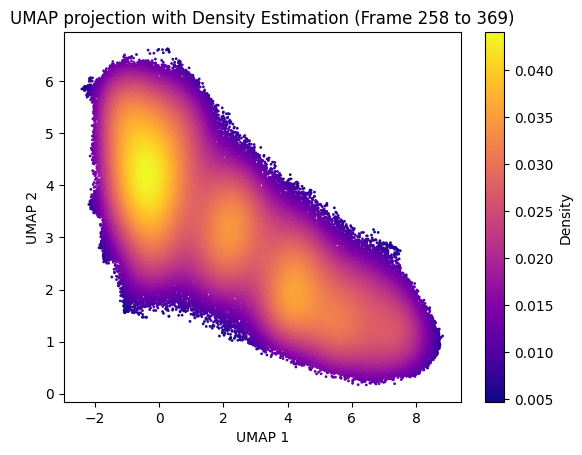

In [60]:
# Create the scatter plot with colors based on density
plt.scatter(embedding[:, 0], embedding[:, 1], c=density, cmap='plasma', s=1)
plt.colorbar(label='Density')
plt.title('UMAP projection with Density Estimation (Frame 258 to 369)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [57]:
from scipy.interpolate import griddata

grid_x, grid_y = np.mgrid[embedding[:, 0].min():embedding[:, 0].max():10000j, 
                          embedding[:, 1].min():embedding[:, 1].max():10000j]

# Interpolate the density values onto the grid
grid_density = griddata(embedding, density, (grid_x, grid_y), method='cubic')

# Clip any negative values to zero
grid_density = np.clip(grid_density, a_min=0, a_max=None)

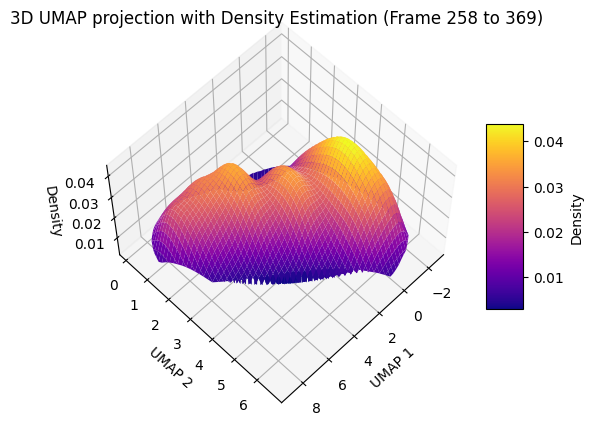

In [65]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the 3D surface plot using a 'viridis' colormap
# We use the interpolated grid_density values as our Z-axis
surf = ax.plot_surface(grid_x, grid_y, grid_density, cmap='plasma', edgecolor='none')

# Add color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label('Density')

# Set labels and title
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('Density')
plt.title('3D UMAP projection with Density Estimation (Frame 258 to 369)')

ax.view_init(elev=60, azim=45)  # elev is the elevation angle, azim is the azimuth angle


# Show plot
plt.show()

c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


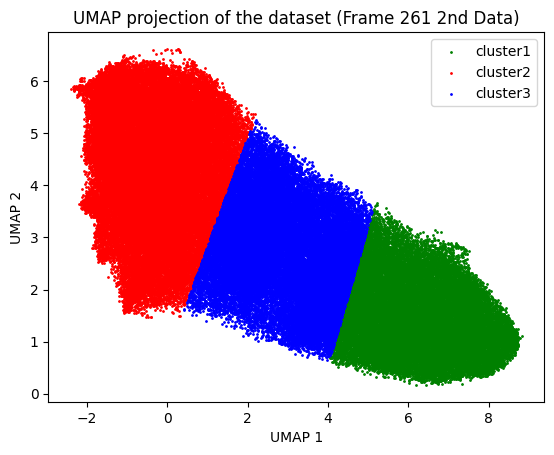

In [67]:
from sklearn.cluster import KMeans

n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster,init='random')
clusters = kmeans.fit_predict(embedding)

colors = ['g','r','b','y']
for i in range(n_cluster):
    cluster = embedding[clusters==i]
    plt.scatter(cluster[:,0], cluster [:,1], color=colors[i], label=f'cluster{i+1}',s=1 )

plt.title("UMAP projection of the dataset (Frame 261 2nd Data)")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

In [68]:
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster,init='random')
clusters = kmeans.fit_predict(df_features)

c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\ljd567\AppData\Local\miniconda3\envs\cellshape\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


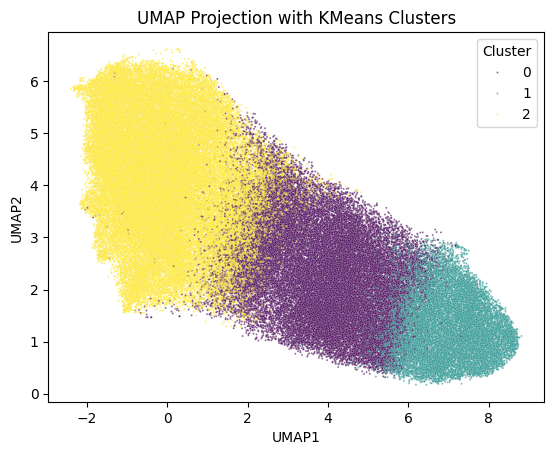

In [75]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# Standardize the features
scalar = StandardScaler()
scaled_features = scalar.fit_transform(np.asarray(df_features.iloc[:, 0:64]))

# KMeans clustering
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, init='random')
clusters = kmeans.fit_predict(scaled_features)

# Combine UMAP embeddings with cluster labels
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = clusters

# Plotting
plt.figure()
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', data=umap_df, s=2, alpha=0.6)
plt.title('UMAP Projection with KMeans Clusters')
plt.show()